In [17]:
import time, sys
sys.path.append('/home/yilingh/SI-Interaction')
import multiprocessing as mp

from selectinf.Simulation.simulation_helpers import (
    generate_gaussian_instance_nonlinear_interaction_simple)

from selectinf.group_lasso_query import (group_lasso)
from selectinf.Simulation.simulation_helpers import (naive_inference_inter,
                                                     data_splitting_inter,
                                                     MLE_inference_inter)
from selectinf.Simulation.plotting_helpers import *
from selectinf.Simulation.H1.nonlinear_H1_helpers import *

In [19]:
args = [(i*2, (i+1)*2) for i in range(4)]
with mp.Pool(processes=4) as pool:
    results = pool.starmap(vary_SNR, args)

2 th simulation done
Equally spaced quantile knots used.
Main: 0.030620991574208733
Interaction: 0.039345719114207915
induced SNR: 0.5000000000000001
Naive Selected Groups: 3
DS Selected Groups: 7
MLE Selected Groups: 4
Equally spaced quantile knots used.
Main: 0.031212396522852143
Interaction: 0.039477722719366636
induced SNR: 1.0
Naive Selected Groups: 4
DS Selected Groups: 4
MLE Selected Groups: 4
Equally spaced quantile knots used.
Main: 0.03188992395387073
Interaction: 0.039276990979678336
induced SNR: 2.0000000000000004
Naive Selected Groups: 7
DS Selected Groups: 8
MLE Selected Groups: 6
Equally spaced quantile knots used.
Main: 0.030088561216239696
Interaction: 0.03916988319931142
induced SNR: 5.000000000000001
Naive Selected Groups: 7
DS Selected Groups: 3
MLE Selected Groups: 8
3 th simulation done
Equally spaced quantile knots used.
Main: 0.03158548357171878
Interaction: 0.03941452639240377
induced SNR: 0.5000000000000001
Naive Selected Groups: 3
DS Selected Groups: 5
MLE Se

In [20]:
list_of_oper = [tup[0] for tup in results]

In [21]:
list_of_pval = [tup[1] for tup in results]

In [22]:
list_of_targets = [tup[2] for tup in results]

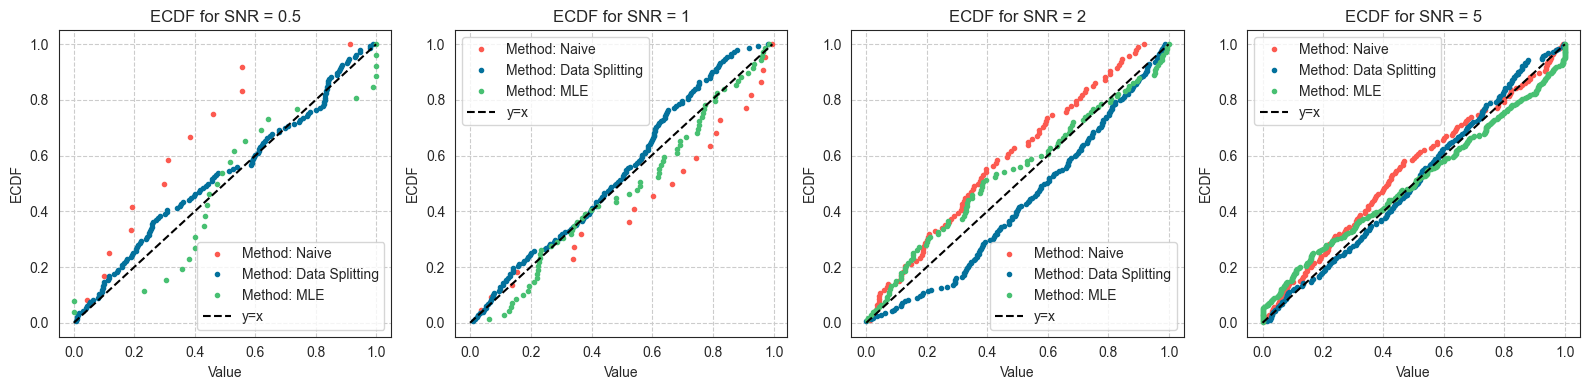

In [23]:
plot_ecdfs(combine_nested_lists(list_of_pval), xaxis="SNR")

# Plot boxplots of projected targets

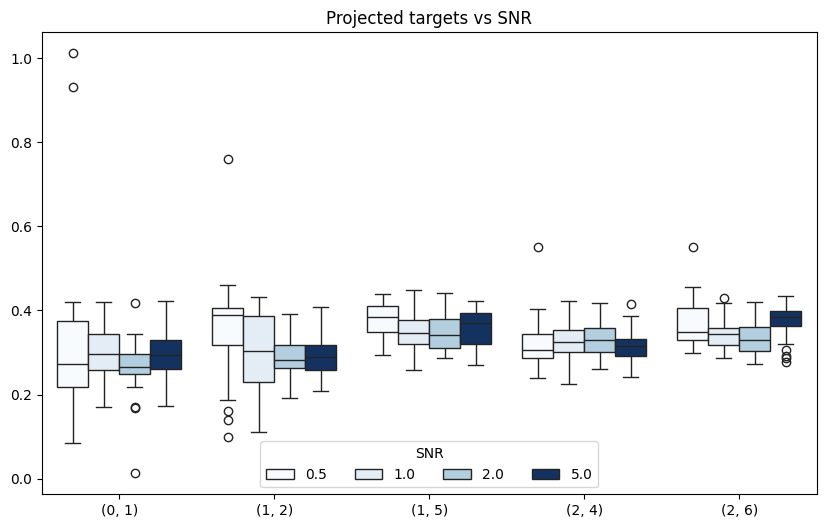

In [11]:
plot_multi_targets(combine_lists(list_of_targets), xaxis="SNR")

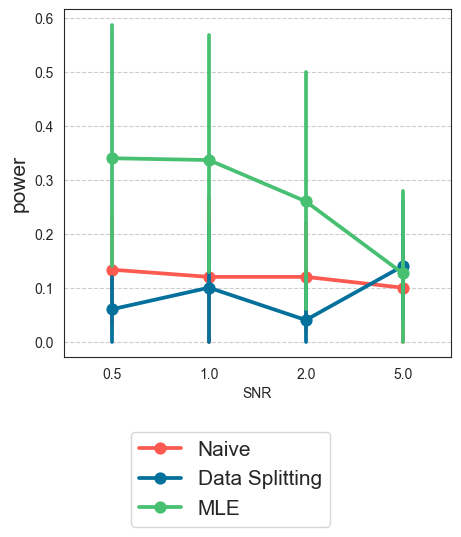

In [14]:
point_plot_multimetrics(oper_char_df=pd.DataFrame(combine_lists(list_of_oper)),
                        x_axis="SNR",
                        hue="method",
                        metric_list=["power"])

# Fix Interaction Signal, Vary Main

In [48]:
# A dictionary recording simulation results and metrics
oper_char = {}
oper_char["coverage rate"] = []
oper_char["avg length"] = []
oper_char["method"] = []
oper_char["rho"] = []
oper_char["signal"] = []
oper_char["main signal"] = []
oper_char["target"] = []
oper_char["power"] = []

# Dictionary of projected targets, over all simulation parameters
target_dict = {}
target_dict["parameter"] = []
target_dict["target"] = []
target_dict["target id"] = []
target_dict["method"] = []

# A dictionary recording p-values for each true interaction
# over all simulation results.
# Each simulation parameter (here parameter_list contain a list of main signal strengths 
# to be considered) has a corresponding dictionary of results
parameter_list = [10, 5, 2, 1]
pval_dict = {}
for x in parameter_list:
    pval_dict[x] = {}
    for m in ['Naive', 'Data Splitting', 'MLE']:
        pval_dict[x][m] = []

# Group lasso solver constructor
const = group_lasso.gaussian
active_inter_list_true = np.array([[0,1], [1,2], [2,4], [1,5], [2,6]])
active_inter_list_true_list = [(x[0],x[1]) for x in active_inter_list_true]

#p = 50
rho = 0.5 # Correlation of signal covariates (amongst themselves), and noise.
sig = 0.05 # Controlling interaction vs main signals. 
           # Setting it this way generates comparable main 
           # and interaction signals
weights = 2 # Group Lasso weights
s_inter = 5 # Number of true interactions
p_nl = 20 # Number of nonlinear covariates

for i in range(100):
    print(i,"th simulation done")
    #for rho in [0.25, 0.5, 0.75]:
    #for sig in [0.1, 0.25, 0.5, 1]:
    #for SNR in [0.1, 0.25, 0.5, 1]:
    for main_sig in parameter_list:
        while True:
            # Generating a (X, Y) pair, and corresponding basis expansion
            # The 'weakhierarchy' argument is overridden by setting 
            # `active_inter_list`.
            (design, data_interaction, Y, Y_mean, data_combined,
             groups, active, active_inter_adj, active_inter_list, gamma) \
                = (generate_gaussian_instance_nonlinear_interaction_simple
                   (n=500, p_nl=p_nl, rho=rho, full_corr=False, rho_noise=rho,
                    SNR = None, main_signal=main_sig, noise_sd=0.25,
                    nknots = 6, degree = 2, interaction_signal=sig,
                    random_signs=False, scale=True, center=False,
                    structure='weakhierarchy', s_interaction=s_inter,
                    intercept=True, active_inter_list=active_inter_list_true, 
                    return_gamma=True))
            
            # Performing Naive inference using 'all pairs'
            coverages, lengths, selected_inter, p_values, targets, idx \
                = naive_inference_inter(X=design, Y=Y, groups=groups,
                                        Y_mean=Y_mean, const=const,
                                        n_features=20, interactions=data_interaction,
                                        weight_frac=weights, level=0.9, mode='weakhierarchy',
                                        solve_only=False, continued=False,
                                        parallel=False, p_val=True, 
                                        return_pivot=True, intercept=True, 
                                        target_ids=active_inter_list_true_list)
            
            noselection = coverages is None
            
            # Continue if Naive yields a nonempty group lasso selection
            # (this is almost always the case)
            if not noselection:
                # Performing data splitting using 'all pairs'
                (coverages_ds, lengths_ds, selected_inter_ds, 
                 p_values_ds, targets_ds, idx_ds) \
                    = data_splitting_inter(X=design, Y=Y, groups=groups,
                                   Y_mean=Y_mean, const=const,
                                   n_features=20, interactions=data_interaction,
                                   proportion=0.5,
                                   weight_frac=weights, level=0.9, mode='weakhierarchy',
                                   solve_only=False, continued=False, parallel=False,
                                   p_val=True, target_ids=active_inter_list_true_list)
                noselection = coverages_ds is None
            
            # Continue if data splitting yields a nonempty group lasso selection
            # (this is almost always the case)    
            if not noselection:
                # Performing MLE using 'all pairs'
                coverages_MLE, lengths_MLE, selected_inter_MLE, p_values_MLE, targets_MLE, idx_MLE\
                    = (MLE_inference_inter
                       (X=design, Y=Y, Y_mean=Y_mean, groups=groups,
                        n_features=p_nl, interactions=data_interaction,
                        intercept=True, proportion=0.5, weight_frac=weights,
                        level=0.9, mode='weakhierarchy', solve_only=False, 
                        continued=False, parallel=False, p_val=True, 
                        target_ids=active_inter_list_true_list))
                noselection = coverages_MLE is None
            
            # Collect results if all three methods yields 
            # nonempty first-stage selection
            if not noselection:
                # Naive
                oper_char["coverage rate"].append(np.mean(coverages))
                oper_char["avg length"].append(np.mean(lengths))
                oper_char["method"].append('Naive')
                oper_char["signal"].append(sig)
                oper_char["main signal"].append(main_sig)
                oper_char["rho"].append(rho)
                #oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets[0])
                pval_dict[main_sig]['Naive'] += (p_values)
                oper_char["power"].append(calculate_power(p_values, targets, 0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets, parameter=main_sig,
                               method="Naive", idx=idx)
    
                # Data splitting
                oper_char["coverage rate"].append(np.mean(coverages_ds))
                oper_char["avg length"].append(np.mean(lengths_ds))
                oper_char["method"].append('Data Splitting')
                oper_char["signal"].append(sig)
                oper_char["main signal"].append(main_sig)
                oper_char["rho"].append(rho)
                #oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets_ds[0])
                pval_dict[main_sig]['Data Splitting'] += (p_values_ds)
                oper_char["power"].append(calculate_power(p_values_ds, targets_ds, 0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets_ds, parameter=main_sig,
                               method="Data Splitting", idx=idx_ds)
    
                
                # MLE
                oper_char["coverage rate"].append(np.mean(coverages_MLE))
                oper_char["avg length"].append(np.mean(lengths_MLE))
                oper_char["method"].append('MLE')
                oper_char["signal"].append(sig)
                oper_char["main signal"].append(main_sig)
                oper_char["rho"].append(rho)
                #oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets_MLE[0])
                pval_dict[main_sig]['MLE'] += (p_values_MLE)
                oper_char["power"].append(calculate_power(p_values_MLE, 
                                                          targets_MLE,
                                                          0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets_MLE, parameter=main_sig,
                               method="MLE", idx=idx_MLE)
                
                break

0 th simulation done
Equally spaced quantile knots used.
Main: 0.3165252424185948
Interaction: 0.19503393198094873
induced SNR: 3.3907489210856094
Naive Selected Groups: 7
DS Selected Groups: 9
MLE Selected Groups: 11
Equally spaced quantile knots used.
Main: 0.16572916937947946
Interaction: 0.19178775316361096
induced SNR: 1.606472812157671
Naive Selected Groups: 4
DS Selected Groups: 10
MLE Selected Groups: 6
Equally spaced quantile knots used.
Main: 0.06319670543969737
Interaction: 0.20004996174356302
induced SNR: 0.9511539060061651
Naive Selected Groups: 5
DS Selected Groups: 6
MLE Selected Groups: 8
Equally spaced quantile knots used.
Main: 0.031782618170557435
Interaction: 0.20140305113844773
induced SNR: 0.7884932112417036
Naive Selected Groups: 5
DS Selected Groups: 5
MLE Selected Groups: 6
1 th simulation done
Equally spaced quantile knots used.
Main: 0.31898262594420207
Interaction: 0.19328997950705865
induced SNR: 3.3614423803978672
Naive Selected Groups: 4
DS Selected Group

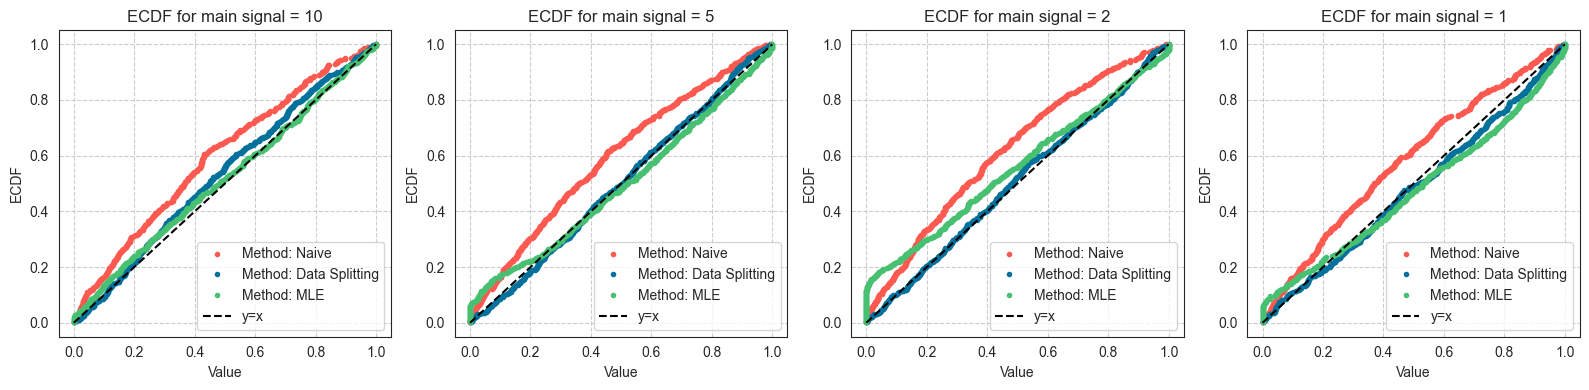

In [49]:
plot_ecdfs(pval_dict, xaxis="main signal")

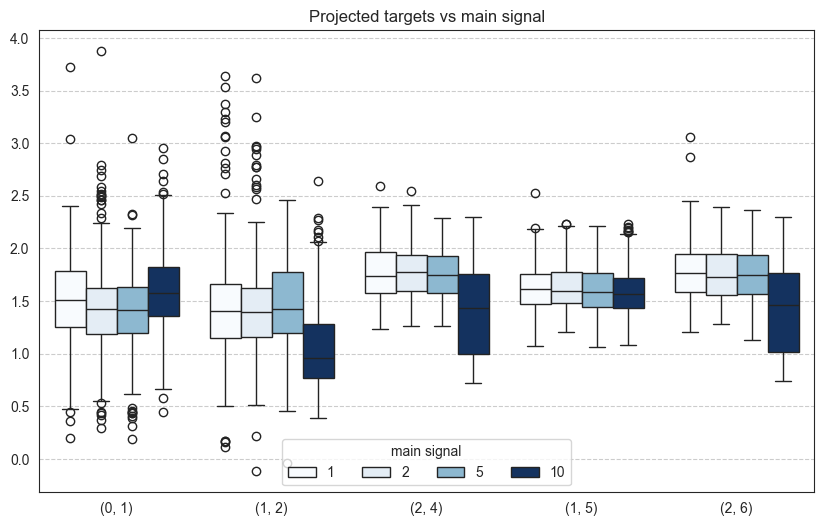

In [50]:
plot_multi_targets(target_dict, xaxis="main signal")

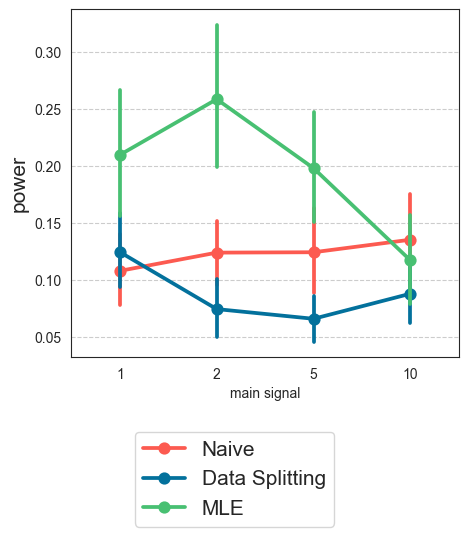

In [51]:
point_plot_multimetrics(oper_char_df=
                        pd.DataFrame(oper_char),
                        x_axis="main signal",
                        hue="method",
                        metric_list=["power"])

# Vary Correlation between Signal and Noise

In [53]:
# A dictionary recording simulation results and metrics
oper_char = {}
oper_char["coverage rate"] = []
oper_char["avg length"] = []
oper_char["method"] = []
oper_char["rho cross"] = []
oper_char["signal"] = []
#oper_char["SNR"] = []
oper_char["target"] = []
oper_char["power"] = []

# A dictionary recording p-values for each true interaction
# over all simulation results.
# Each simulation parameter (here parameter_list contain a list of correlations 
# to be considered) has a corresponding dictionary of results
parameter_list = [0, 0.15, 0.3, 0.45]
pval_dict = {}
for x in parameter_list:
    pval_dict[x] = {}
    for m in ['Naive', 'Data Splitting', 'MLE']:
        pval_dict[x][m] = []

# Dictionary of projected targets, over all simulation parameters
target_dict = {}
target_dict["parameter"] = []
target_dict["target"] = []
target_dict["target id"] = []
target_dict["method"] = []

# Group lasso solver constructor   
const = group_lasso.gaussian

# List and array representations of true interaction indices
active_inter_list_true = np.array([[0,1], [1,2], [2,4], [1,5], [2,6]])
active_inter_list_true_list = [(x[0],x[1]) for x in active_inter_list_true]

#p = 50
rho = 0.5 # Correlation of signal covariates (amongst themselves), and noise.
sig = 0.01 # Controlling interaction vs main signals. 
           # Setting it this way generates comparable main 
           # and interaction signals
weights = 2 # Group Lasso weights
s_inter = 5 # Number of true interactions
p_nl = 20 # Number of nonlinear covariates

for i in range(100):
    print(i,"th simulation done")
    #for rho in [0.25, 0.5, 0.75]:
    #for sig in [0.1, 0.25, 0.5, 1]:
    #for SNR in [0.1, 0.25, 0.5, 1]:
    for rho_cross in parameter_list:
        while True:
            # Generating a (X, Y) pair, and corresponding basis expansion
            # The 'weakhierarchy' argument is overridden by setting 
            # `active_inter_list`.
            (design, data_interaction, Y, Y_mean, data_combined,
             groups, active, active_inter_adj, active_inter_list, gamma) \
                = (generate_gaussian_instance_nonlinear_interaction_simple
                   (n=500, p_nl=p_nl, rho=rho, full_corr=False, 
                    rho_noise=rho, block_corr=True, rho_cross=rho_cross, 
                    SNR = 2, nknots = 6, degree = 2, interaction_signal=sig,
                    random_signs=False, scale=True, center=False,
                    structure='weakhierarchy', s_interaction=s_inter,
                    intercept=True, active_inter_list=active_inter_list_true, 
                    return_gamma=True))
            
            # Performing Naive inference using 'all pairs'
            coverages, lengths, selected_inter, p_values, targets, idx \
                = naive_inference_inter(X=design, Y=Y, groups=groups,
                                        Y_mean=Y_mean, const=const,
                                        n_features=20, interactions=data_interaction,
                                        weight_frac=weights, level=0.9, mode='weakhierarchy',
                                        solve_only=False, continued=False,
                                        parallel=False, p_val=True, 
                                        return_pivot=True, intercept=True, 
                                        target_ids=active_inter_list_true_list)
            
            noselection = coverages is None
                
            # Continue if Naive yields a nonempty group lasso selection
            # (this is almost always the case)
            if not noselection:
                # Performing data splitting using 'all pairs'
                (coverages_ds, lengths_ds, selected_inter_ds, 
                 p_values_ds, targets_ds, idx_ds) \
                    = data_splitting_inter(X=design, Y=Y, groups=groups,
                                   Y_mean=Y_mean, const=const,
                                   n_features=20, interactions=data_interaction,
                                   proportion=0.5,
                                   weight_frac=weights, level=0.9, mode='weakhierarchy',
                                   solve_only=False, continued=False, parallel=False,
                                   p_val=True, target_ids=active_inter_list_true_list)
                noselection = coverages_ds is None
            
            # Continue if data splitting yields a nonempty group lasso selection
            # (this is almost always the case)    
            if not noselection:
                # Performing MLE using 'all pairs'
                coverages_MLE, lengths_MLE, selected_inter_MLE, p_values_MLE, targets_MLE, idx_MLE\
                    = (MLE_inference_inter
                       (X=design, Y=Y, Y_mean=Y_mean, groups=groups,
                        n_features=p_nl, interactions=data_interaction,
                        intercept=True, proportion=0.5, weight_frac=weights,
                        level=0.9, mode='weakhierarchy', solve_only=False, 
                        continued=False, parallel=False, p_val=True, 
                        target_ids=active_inter_list_true_list))
                noselection = coverages_MLE is None
            
            # Collect results if all three methods yields 
            # nonempty first-stage selection
            if not noselection:
                # Naive
                oper_char["coverage rate"].append(np.mean(coverages))
                oper_char["avg length"].append(np.mean(lengths))
                oper_char["method"].append('Naive')
                oper_char["signal"].append(sig)
                #oper_char["main signal"].append(main_sig)
                oper_char["rho cross"].append(rho_cross)
                #oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets[0])
                pval_dict[rho_cross]['Naive'] += (p_values)
                oper_char["power"].append(calculate_power(p_values, targets, 0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets, parameter=rho_cross,
                               method="Naive", idx=idx)
    
                # Data splitting
                oper_char["coverage rate"].append(np.mean(coverages_ds))
                oper_char["avg length"].append(np.mean(lengths_ds))
                oper_char["method"].append('Data Splitting')
                oper_char["signal"].append(sig)
                #oper_char["main signal"].append(main_sig)
                oper_char["rho cross"].append(rho_cross)
                #oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets_ds[0])
                pval_dict[rho_cross]['Data Splitting'] += (p_values_ds)
                oper_char["power"].append(calculate_power(p_values_ds, targets_ds, 0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets_ds, parameter=rho_cross,
                               method="Data Splitting", idx=idx_ds)
                
                # MLE
                oper_char["coverage rate"].append(np.mean(coverages_MLE))
                oper_char["avg length"].append(np.mean(lengths_MLE))
                oper_char["method"].append('MLE')
                oper_char["signal"].append(sig)
                #oper_char["main signal"].append(main_sig)
                oper_char["rho cross"].append(rho_cross)
                #oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets_MLE[0])
                pval_dict[rho_cross]['MLE'] += (p_values_MLE)
                oper_char["power"].append(calculate_power(p_values_MLE, 
                                                          targets_MLE,
                                                          0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets_MLE, parameter=rho_cross,
                               method="MLE", idx=idx_MLE)
                
                break

0 th simulation done
Equally spaced quantile knots used.
Main: 0.033117829999397524
Interaction: 0.03985444211088909
induced SNR: 2.0000000000000004
Naive Selected Groups: 5
DS Selected Groups: 5
MLE Selected Groups: 6
Equally spaced quantile knots used.
Main: 0.03051664238744149
Interaction: 0.040942242717165775
induced SNR: 2.0000000000000004
Naive Selected Groups: 7
DS Selected Groups: 8
MLE Selected Groups: 10
Equally spaced quantile knots used.
Main: 0.030422976944055893
Interaction: 0.0425863468681606
induced SNR: 2.0000000000000004
Naive Selected Groups: 8
DS Selected Groups: 7
MLE Selected Groups: 7
Equally spaced quantile knots used.
Main: 0.031231497098453315
Interaction: 0.043310397553271464
induced SNR: 2.0000000000000004
Naive Selected Groups: 8
DS Selected Groups: 8
MLE Selected Groups: 8
1 th simulation done
Equally spaced quantile knots used.
Main: 0.03184977042609077
Interaction: 0.03864831405204565
induced SNR: 2.0000000000000004
Naive Selected Groups: 6
DS Selected G

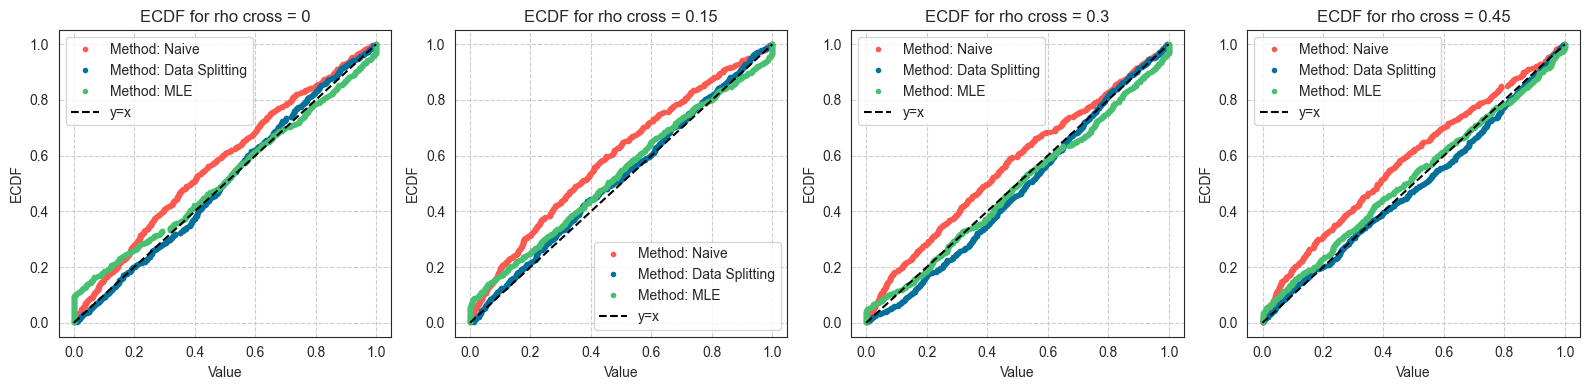

In [54]:
plot_ecdfs(pval_dict, xaxis="rho cross")

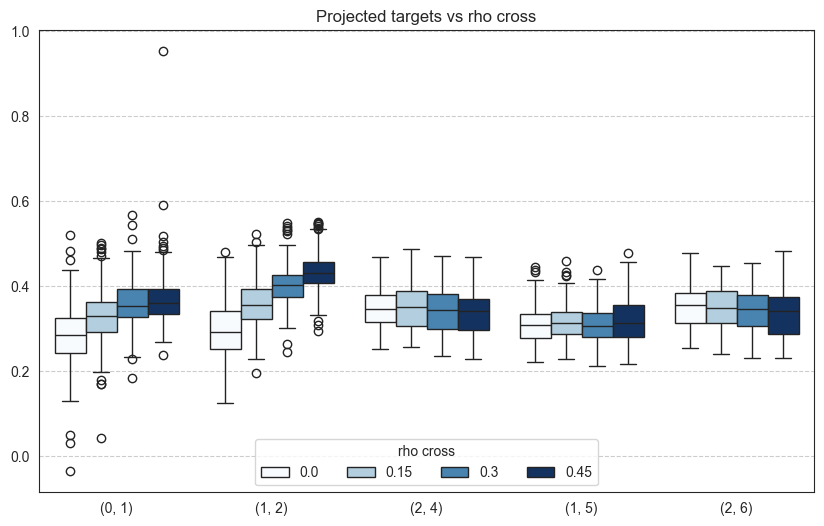

In [55]:
plot_multi_targets(target_dict, xaxis="rho cross")

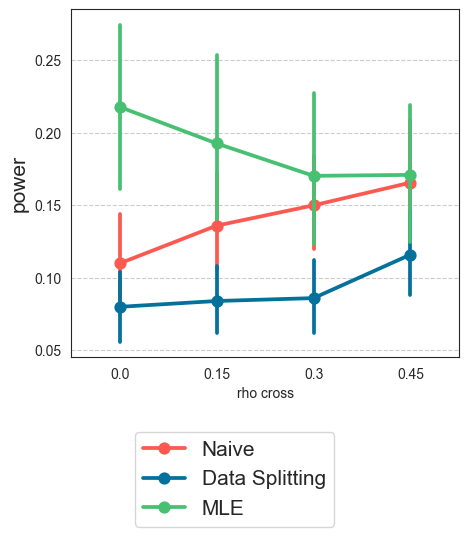

In [56]:
point_plot_multimetrics(oper_char_df=
                        pd.DataFrame(oper_char),
                        x_axis="rho cross",
                        hue="method",
                        metric_list=["power"])

# Fix total SNR, vary main effects

In [35]:
# A dictionary recording simulation results and metrics
oper_char = {}
oper_char["coverage rate"] = []
oper_char["avg length"] = []
oper_char["method"] = []
oper_char["rho"] = []
oper_char["signal"] = []
oper_char["SNR"] = []
oper_char["target"] = []
oper_char["power"] = []

# A dictionary recording p-values for each true interaction
# over all simulation results.
# Each simulation parameter (here parameter_list contain a list of SNRs 
# to be considered) has a corresponding dictionary of results
pval_dict = {}
parameter_list = [0.0001, 0.0005, 0.001, 0.005]
for sig in parameter_list:
    pval_dict[sig] = {}
    for m in ['Naive', 'Data Splitting', 'MLE']:
        pval_dict[sig][m] = []

# Group lasso solver constructor
const = group_lasso.gaussian

# List and array representations of true interaction indices
active_inter_list_true = np.array([[0, 1], [1, 2], [2, 4], [1, 5], [2, 6]])
active_inter_list_true_list = [(x[0], x[1]) for x in active_inter_list_true]

# Dictionary of projected targets, over all simulation parameters
target_dict = {}
target_dict["parameter"] = []
target_dict["target"] = []
target_dict["target id"] = []
target_dict["method"] = []

#p = 50
rho = 0.5  # Correlation of signal covariates (amongst themselves), and noise.
# sig = 0.01  # Controlling interaction vs main signals. 
# Setting it this way generates comparable main 
# and interaction signals
weights = 2  # Group Lasso weights
s_inter = 5  # Number of true interactions
p_nl = 20  # Number of nonlinear covariates
SNR = 1

for i in range(100):
    print(i, "th simulation done")
    for sig in parameter_list:
        while True:
            # Generating a (X, Y) pair, and corresponding basis expansion
            # The 'weakhierarchy' argument is overridden by setting 
            # `active_inter_list`.
            (design, data_interaction, Y, Y_mean, data_combined,
             groups, active, active_inter_adj, active_inter_list, gamma) \
                = (generate_gaussian_instance_nonlinear_interaction_simple
                   (n=500, p_nl=p_nl, rho=rho, full_corr=False, rho_noise=rho,
                    SNR=SNR, nknots=6, degree=2, interaction_signal=sig,
                    random_signs=False, scale=True, center=False,
                    structure='weakhierarchy', s_interaction=s_inter, intercept=True,
                    active_inter_list=active_inter_list_true, return_gamma=True))

            # Performing Naive inference using 'all pairs'
            coverages, lengths, selected_inter, p_values, targets, idx \
                = naive_inference_inter(X=design, Y=Y, groups=groups,
                                        Y_mean=Y_mean, const=const,
                                        n_features=20, interactions=data_interaction,
                                        weight_frac=weights, level=0.9,
                                        mode='allpairs',
                                        solve_only=False, continued=False,
                                        parallel=False, p_val=True,
                                        return_pivot=True, intercept=True,
                                        target_ids=active_inter_list_true_list)

            noselection = coverages is None

            # Continue if Naive yields a nonempty group lasso selection
            # (this is almost always the case)
            if not noselection:
                # Performing data splitting using 'all pairs'
                (coverages_ds, lengths_ds, selected_inter_ds,
                 p_values_ds, targets_ds, idx_ds) \
                    = data_splitting_inter(X=design, Y=Y, groups=groups,
                                           Y_mean=Y_mean, const=const,
                                           n_features=20,
                                           interactions=data_interaction,
                                           proportion=0.5,
                                           weight_frac=weights, level=0.9,
                                           mode='allpairs',
                                           solve_only=False, continued=False,
                                           parallel=False,
                                           p_val=True,
                                           target_ids=active_inter_list_true_list)
                noselection = coverages_ds is None

            # Continue if data splitting yields a nonempty group lasso selection
            # (this is almost always the case)
            if not noselection:
                # Performing MLE using 'all pairs'
                coverages_MLE, lengths_MLE, selected_inter_MLE, p_values_MLE, targets_MLE, idx_MLE \
                    = (MLE_inference_inter
                       (X=design, Y=Y, Y_mean=Y_mean, groups=groups,
                        n_features=p_nl, interactions=data_interaction,
                        intercept=True, proportion=0.5, weight_frac=weights,
                        level=0.9, mode='allpairs', solve_only=False,
                        continued=False, parallel=False, p_val=True,
                        target_ids=active_inter_list_true_list))
                noselection = coverages_MLE is None

            # Collect results if all three methods yields 
            # nonempty first-stage selection
            if not noselection:
                # Naive
                oper_char["coverage rate"].append(np.mean(coverages))
                oper_char["avg length"].append(np.mean(lengths))
                oper_char["method"].append('Naive')
                oper_char["signal"].append(sig)
                oper_char["rho"].append(rho)
                oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets[0])
                pval_dict[sig]['Naive'] += (p_values)
                oper_char["power"].append(calculate_power(p_values, targets, 0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets, parameter=sig,
                               method="Naive", idx=idx)

                # Data splitting
                oper_char["coverage rate"].append(np.mean(coverages_ds))
                oper_char["avg length"].append(np.mean(lengths_ds))
                oper_char["method"].append('Data Splitting')
                oper_char["signal"].append(sig)
                oper_char["rho"].append(rho)
                oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets_ds[0])
                pval_dict[sig]['Data Splitting'] += (p_values_ds)
                oper_char["power"].append(calculate_power(p_values_ds, targets_ds, 0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets_ds, parameter=sig,
                               method="Data Splitting", idx=idx_ds)

                # MLE
                oper_char["coverage rate"].append(np.mean(coverages_MLE))
                oper_char["avg length"].append(np.mean(lengths_MLE))
                oper_char["method"].append('MLE')
                oper_char["signal"].append(sig)
                oper_char["rho"].append(rho)
                oper_char["SNR"].append(SNR)
                oper_char["target"].append(targets_MLE[0])
                pval_dict[sig]['MLE'] += (p_values_MLE)
                oper_char["power"].append(calculate_power(p_values_MLE,
                                                          targets_MLE,
                                                          0.1))
                update_targets(dict=target_dict,
                               true_inter_list=active_inter_list_true_list,
                               targets=targets_MLE, parameter=sig,
                               method="MLE", idx=idx_MLE)

                break

0 th simulation done
Equally spaced quantile knots used.
Main: 0.03059160908878645
Interaction: 0.0004011746766666368
induced SNR: 1.0
Naive Selected Groups: 3
DS Selected Groups: 6
Equally spaced quantile knots used.
Main: 0.031271144946084004
Interaction: 0.0003901941465875779
induced SNR: 1.0
Naive Selected Groups: 3
DS Selected Groups: 9
MLE Selected Groups: 4
Equally spaced quantile knots used.
Main: 0.031057822514018854
Interaction: 0.0019867500735915814
induced SNR: 1.0
Naive Selected Groups: 3
DS Selected Groups: 7
MLE Selected Groups: 4
Equally spaced quantile knots used.
Main: 0.03201621403634735
Interaction: 0.003888047434351613
induced SNR: 1.0
Naive Selected Groups: 3
DS Selected Groups: 9
MLE Selected Groups: 4
Equally spaced quantile knots used.
Main: 0.03253857718278813
Interaction: 0.01899553483008991
induced SNR: 1.0
Naive Selected Groups: 3
DS Selected Groups: 3
MLE Selected Groups: 6
1 th simulation done
Equally spaced quantile knots used.
Main: 0.03241477033502535


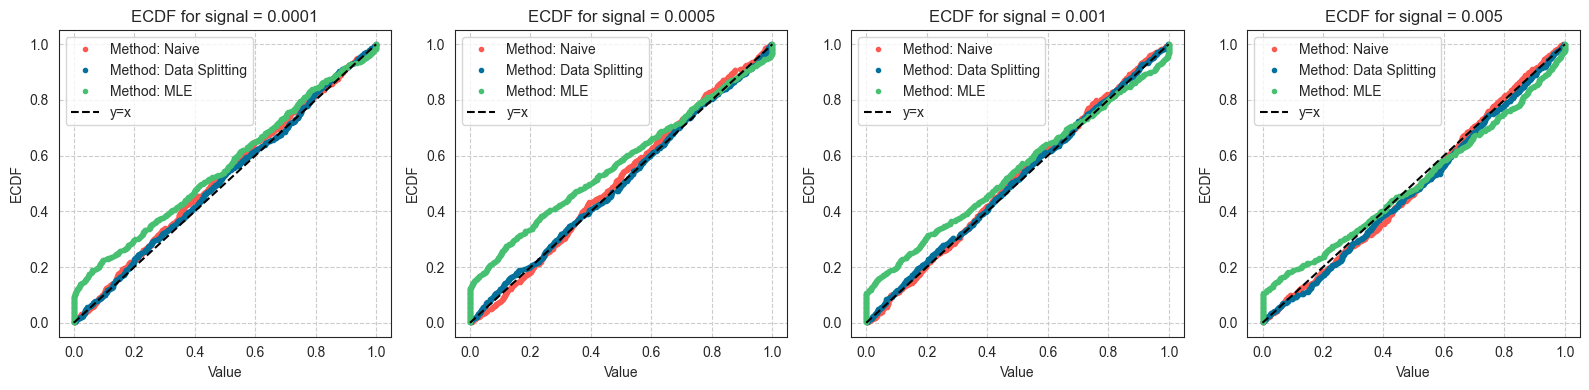

In [36]:
plot_ecdfs(pval_dict, xaxis="signal")

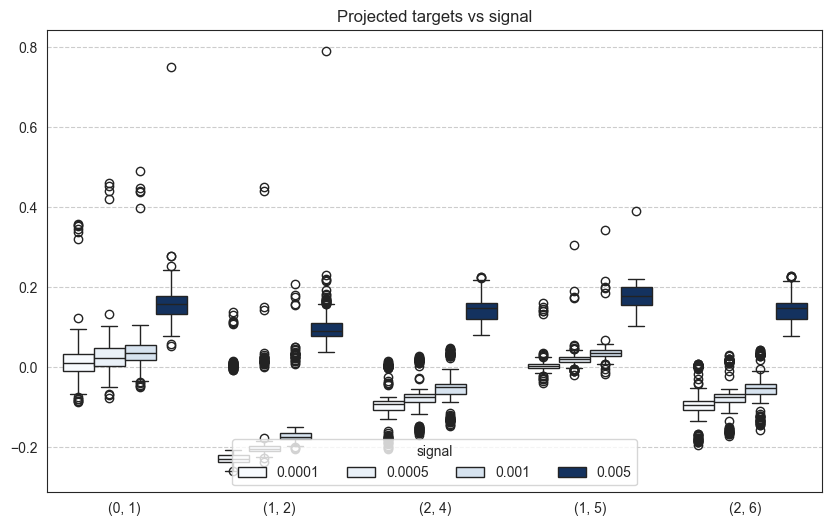

In [37]:
plot_multi_targets(target_dict, xaxis="signal")

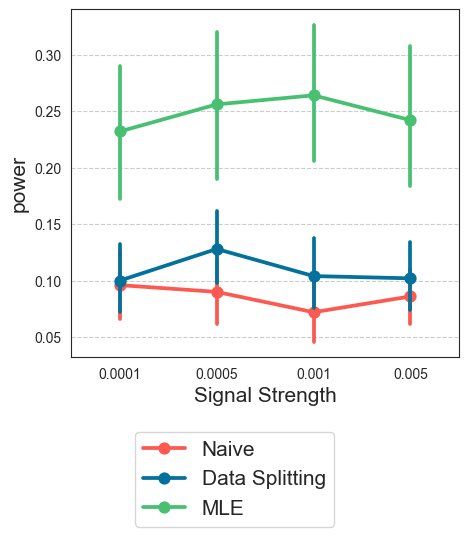

In [38]:
point_plot_multimetrics(oper_char_df=
                        pd.DataFrame(oper_char),
                        x_axis="signal",
                        hue="method",
                        metric_list=["power"])